In [1]:
import numpy as np
import pandas as pd
import pyrepseq as prs
import pyrepseq.plotting as rsp
import matplotlib.pyplot as plt
import scipy.stats
import random
import matplotlib.ticker as ticker

import pydiver

plt.style.use('estimator.mplstyle')

In [2]:
data = pd.read_csv('data/metarepertoire.csv.gz', index_col=0)
len(data)

30000000

In [3]:
'%e'%(1/prs.pc(data['amino_acid']))

'1.452179e+06'

In [4]:
sample_sizes = list(sorted(pd.unique([int(v) for v in np.logspace(np.log10(500.1), np.log10(50000.1), 15)])))
sample_sizes

[500,
 694,
 965,
 1341,
 1864,
 2590,
 3598,
 5000,
 6948,
 9654,
 13414,
 18638,
 25898,
 35984,
 50000]

In [5]:
nrepetitions = int(data.shape[0]//max(sample_sizes))
nrepetitions

600

In [6]:
estimators = ['Unbiased', 'Grundmann', 'Plugin']

In [7]:
data.shape

(30000000, 1)

In [8]:
results_list = []
for N in sample_sizes:
    results = {estimator: [] for estimator in estimators}
    pcs = []
    nrepetitions = int(data.shape[0]//N)
    for i in range(nrepetitions):
        d = data.iloc[i*N:(i+1)*N]
        counts = pydiver.counts_from_sample(d['amino_acid'])
        pcs.append(pydiver.pc(counts))
        for estimator in estimators:
            results[estimator].append(pydiver.varpc(counts, method=estimator.lower()))
    theory = np.var(pcs)
    for estimator in estimators:
        values = results[estimator]
        variance = np.var(values)
        bias = np.mean(values)-theory
        results_list.append([estimator, N, bias, variance, theory])
results_columns = ['estimator', 'N', 'bias', 'variance', 'theory']
df = pd.DataFrame(data=results_list, columns=results_columns)
df['hatvarvar_norm'] = df['variance']/df['theory']**2
df['hatvarbias_fraction'] = df['bias']/df['theory']
df['logN'] = np.log10(df['N'])

In [9]:
all_counts = data['amino_acid'].value_counts()

In [10]:
k=1/pydiver.pc_sample(data['amino_acid'])
'%e'%k

'1.452179e+06'

In [11]:
def symlog(x):
    return np.sign(x)*np.log10(np.abs(x)+1)

/home/andreas/mambaforge/lib/python3.10/site-packages/pyrepseq/plotting.py:71: RuntimeWarning: divide by zero encountered in log10
  transform_y(scaley * np.arange(sorted_data.size) / norm),


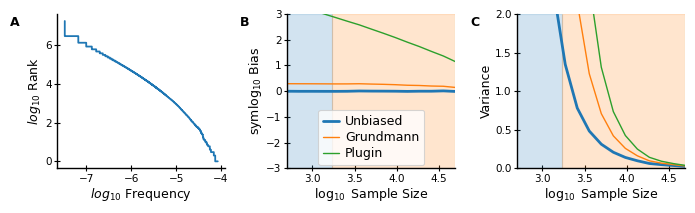

In [12]:
fig, axes = plt.subplots(figsize=(7.0, 2.2), ncols=3, nrows=1, sharex=False)

P = all_counts/np.sum(all_counts)

rsp.rankfrequency(P, ax=axes[0], transform_x=np.log10, transform_y=np.log10, log_x=False, log_y=False)
axes[0].set_xlabel('$log_{10}$ Frequency')
axes[0].set_ylabel('$log_{10}$ Rank')    

axes[1].axhline(0.0, c='k')
for ax in axes[1:]:
    Nma = (2*k)**.5
    ax.axvspan(np.log10(min(sample_sizes)), np.log10(Nma), alpha=.2, color='C0')
    ax.axvspan(np.log10(Nma), np.log10(k), alpha=.2, color='C1')
    ax.axvspan(np.log10(k), np.log10(max(sample_sizes)), alpha=.2, color='C2')
for i, estimator in enumerate(estimators):
    mask = df['estimator'] == estimator
    df[mask].plot(x='logN',
                y='hatvarvar_norm',
                kind='line',
                logx=False,
                logy=False,
                ax=axes[2],
                lw=2 if estimator=='Unbiased' else 1,
                c='C'+str(i),
                label=estimator)
    df['symlogbias'] = symlog(df['hatvarbias_fraction'])
    df[mask].plot(x='logN',
                    y='symlogbias',
                kind='line',
                logx=False,
                ax=axes[1],
                lw=2 if estimator=='Unbiased' else 1,
                c='C'+str(i),
                label=estimator)
axes[2].set_ylabel('Variance')
axes[1].set_ylabel('symlog$_{10}$ Bias')
for ax in axes[1:]:
    ax.set_xlabel('$\log_{10}$ Sample Size')
    ax.set_xlim(np.log10(min(sample_sizes)), np.log10(max(sample_sizes)))
axes[1].set_ylim(-3.0, 3.0)
axes[2].set_ylim(0.0, 2.0)
axes[1].legend(frameon=True, ncol=1, loc='lower center', fontsize='medium')
axes[2].get_legend().remove()


rsp.label_axes(fig, xy=(-0.28, 0.99))
fig.tight_layout()
fig.savefig('svgs/figS5.svg')